<a href="https://colab.research.google.com/github/manju1201/Flipkart_Data_Classification_using_Description/blob/main/4_Product_Classification_Using_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import re 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

# Loading Datasets

In [2]:
desc = pd.read_csv('/content/drive/MyDrive/MIDAS/desc.csv')
category = pd.read_csv('/content/drive/MyDrive/MIDAS/cat.csv')
desc.head(2)

,Unnamed: 0,uniq_id,description
0,0,c2d766ca982eca8304150849735ffef9,key feature alisha solid woman cycling short c...
1,1,7f7036a6d550aaa89d34c77bd39a5e48,fabhomedecor fabric double sofa bed finish col...


In [3]:
category.head(2)

,Unnamed: 0,uniq_id,primary_category
0,0,c2d766ca982eca8304150849735ffef9,Clothing
1,1,7f7036a6d550aaa89d34c77bd39a5e48,Furniture


Analysis on Primary Category

In [4]:
grouped_labels = category.groupby("primary_category", sort='count').size().reset_index(name='count')
grouped_labels.primary_category.describe()

count                        27
unique                       27
top       Bags, Wallets & Belts
freq                          1
Name: primary_category, dtype: object

In [5]:
num_classes = 27
grouped_labels = category.groupby("primary_category").size().reset_index(name='count')
most_common_labels = grouped_labels.nlargest(num_classes, columns="count")
category.primary_category = category.primary_category.apply(lambda label : label if label in most_common_labels.primary_category.values else None)
category = category.dropna()

In [6]:
desc = desc.rename(columns = {'Unnamed: 0': 'Id'}, inplace = False)

In [7]:
category = category.rename(columns = {'Unnamed: 0': 'Id'}, inplace = False)

In [8]:
def labels_for_decription(cat_id):
    return category[category['Id'] == cat_id].primary_category.values

def add_labels_column(row):
    row['primary_category'] = labels_for_decription(row['Id'])
    return row

desc = desc.apply(add_labels_column, axis=1)

In [9]:
pd.set_option('display.max_colwidth', 400)
desc[['Id', 'description', 'primary_category']].head()

,Id,description,primary_category
0,0,key feature alisha solid woman cycling short cotton lycra navy red navy specification alisha solid woman cycling short short detail number content sale package pack fabric cotton lycra type cycling short general detail pattern solid ideal woman fabric care gentle machine wash lukewarm water bleach additional detail style code altht box short,[Clothing]
1,1,fabhomedecor fabric double sofa bed finish color leatherette black mechanism type pull price fine deep seating experience save space new click clack sofa bed easy fold vice versa simple click clack mechanism chrome leg mango wood frame long term durability double cushioned sofa bed provide extra softness make fine seating experience double bed easily sleep two specification fabhomedecor fabric...,[Furniture]
2,2,key feature belly sandal wedge heel casuals belly price material synthetic lifestyle casual heel type wedge warranty type manufacturer product warranty manufacturing defect day care instruction allow pair shoe air odorize regular basis use shoe bag prevent stain mildew dust dry dirt surface using clean cloth use polish shiner specification belly general ideal woman occasion casual shoe detail ...,[Footwear]
3,3,key feature alisha solid woman cycling short cotton lycra black red specification alisha solid woman cycling short short detail number content sale package pack fabric cotton lycra type cycling short general detail pattern solid ideal woman fabric care gentle machine wash lukewarm water bleach additional detail style code altght box short,[Clothing]
4,4,specification sicons purpose arnica dog shampoo general pet type dog brand sicons quantity model number type purpose fragrance arnica form factor liquid box sale package shampoo sicons dog fashion arnica,[Pet Supplies]


In [10]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(desc.primary_category)
labels = multilabel_binarizer.classes_

maxlen = 180
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(desc.description)

def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)


def prediction_to_label(prediction):
    tag_prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(tag_prob, key=lambda kv: kv[1], reverse=True))

# Train Test Split

In [11]:
x = get_features(desc.description)
y = multilabel_binarizer.transform(desc.primary_category)
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

(19997, 180)


# Class Weighting since the distribution of data is not equal

In [12]:
most_common_labels['class_weight'] = len(category) / most_common_labels['count']
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_labels[most_common_labels['primary_category'] == label]['class_weight'].values[0]
    
most_common_labels.head()

,primary_category,count,class_weight
5,Clothing,6341,3.153604
16,Jewellery,3545,5.640903
7,Footwear,1263,15.832937
18,Mobiles & Accessories,1110,18.015315
0,Automotive,1029,19.433431


CNN Model

In [13]:
filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(), 
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='/content/drive/MyDrive/MIDAS/model-conv1d.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    class_weight=class_weight,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 20)           100000    
_________________________________________________________________
dropout (Dropout)            (None, 180, 20)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 178, 300)          18300     
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 27)                8127      
_________________________________________________________________
activation (Activation)      (None, 27)                0         
Total params: 126,427
Trainable params: 126,427
Non-trainable params: 0
__________________________________________________

# Testing 

In [14]:
cnn_model = keras.models.load_model('/content/drive/MyDrive/MIDAS/model-conv1d.h5')
metrics = cnn_model.evaluate(x_test, y_test)
pred = np.argmax(cnn_model.predict(x_test), axis=-1)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

125/125 [==============================] - 1s 9ms/step - loss: 0.0096 - categorical_accuracy: 0.9685
loss: 0.009573369286954403
categorical_accuracy: 0.968500018119812


# Plots

In [15]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Test acc')
    plt.title('Training and Test accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and Test loss')
    plt.legend()

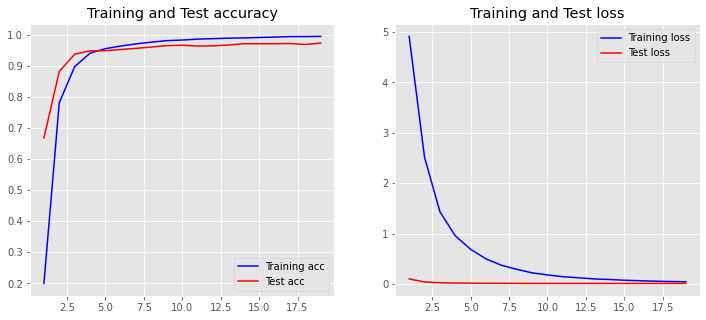

In [16]:
plot_history(history)